# Initial setup


## Pip installs

In [1]:
# Various pip
!pip install tensorflow
!pip install transformers
!pip install datasets
!pip install wordfreq

## Imports

In [2]:
# Dataframe management
import pandas as pd

# Data manipulation
import numpy as np
import random
import os

# NNs
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Model

# Transformers
import transformers
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Convert to HuggingFace dataset
import pyarrow as pa
from datasets import Dataset
import datasets

# Sklearn for train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import BernoulliNB

# Wordfreq to get the italian wordssss
from wordfreq import top_n_list

# File imports
#from google.colab import drive

## Get the datasets

In [3]:
#drive.mount('/content/drive')

In [4]:
#PER FAVORE NON CANCELLATE :(
#PATH_ELISA_MAIN_DATA = '/content/drive/My Drive/NLP_HATESPEECH/data/mainDataEN.csv'
#PATH_ELISA_HASPEEDE2 = '/content/drive/My Drive/NLP_HATESPEECH/haspeede2_dev/haspeede2_dev_taskAB.tsv'
#PATH_ELISA_MISOGYNY_DATA = '/content/drive/My Drive/NLP_HATESPEECH/misogyny_data/AMI2020_TrainingSet/AMI2020_training_raw.tsv'

# Dataset preprocessing

In [5]:
# Get dataset
#df_en = pd.read_csv(PATH_ELISA_MAIN_DATA)
#df_ita_hs = pd.read_csv(PATH_ELISA_HASPEEDE2, sep='\t')
#df_ita_m = pd.read_csv(PATH_ELISA_MISOGYNY_DATA, sep="\t")
df_en = pd.read_csv("mainDataEN.csv")
df_ita_hs = pd.read_csv("haspeede2_dev_taskAB.tsv", sep='\t')
df_ita_m = pd.read_csv("AMI2020_training_raw.tsv", sep="\t")

In [6]:
df_en.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
df_ita_hs.head()

,id,text,hs,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0


In [8]:
df_ita_m.head()

,id,text,misogynous,aggressiveness
0,1,@KassemAmin4 @Laylasexgdr Fatti trovare te lo...,1,1
1,2,@meb Tu dovresti ricominciare dai semafori a f...,1,1
2,3,"Amore,sei presentabile? Xchè così via Skype ti...",1,1
3,4,"@Il_nulla Salvo poi mandare la culona a Mosca,...",1,0
4,5,@GiorgiaMeloni @FratellidItaIia Vediamo Gentil...,1,1


## Uniform hate speech in a single column in the eng dataset

In [9]:
def is_hate_speech(df):
  if df['class'] == 2:
    return 0 # No hate speech
  else:
     return 1 # Hate speech

df_en['hate_speech'] = df_en.apply(is_hate_speech, axis=1)

df_en = df_en.drop(['Unnamed: 0','count', 'offensive_language', 'neither', 'class'], axis=1)

## Uniform hate speech in a single column in the ita datasets

In [10]:
# Stereotypes are considered as hate speech
df_ita_hs['hate_speech'] = df_ita_hs['stereotype'] | df_ita_hs['hs']
df_ita_hs = df_ita_hs.drop(['id', 'stereotype', 'hs'], axis=1)
df_ita_hs = df_ita_hs.rename(columns={'text ': 'text'}) #there was a space

# Merge 'misogynous' and 'aggressiveness' column into a new hate speech column.
df_ita_m['hate_speech'] = df_ita_m['misogynous'] | df_ita_m['aggressiveness']
df_ita_m = df_ita_m.drop(['id', 'misogynous', 'aggressiveness'], axis=1)

## Create a single uniform ita dataset

In [11]:
# Concatenate the datasets vertically
df_ita = pd.concat([df_ita_hs, df_ita_m], axis=0, ignore_index=True)

# Reset the index of the merged dataset
df_ita = df_ita.reset_index(drop=True)

In [12]:
df_en.head()

,hate_speech,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [13]:
df_ita.head()

,text,hate_speech
0,"È terrorismo anche questo, per mettere in uno ...",0
1,@user @user infatti finché ci hanno guadagnato...,0
2,"Corriere: Tangenti, Mafia Capitale dimenticata...",0
3,"@user ad uno ad uno, perché quando i migranti ...",0
4,Il divertimento del giorno? Trovare i patrioti...,0


In [14]:
df_en[df_en['hate_speech'] == 0]

,hate_speech,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
40,0,""" momma said no pussy cats inside my doghouse """
63,0,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,0,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,0,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."
...,...,...
24736,0,yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...
24737,0,yea so about @N_tel 's new friend.. all my fri...
24767,0,"you know what they say, the early bird gets th..."
24779,0,"you've gone and broke the wrong heart baby, an..."


In [15]:
df_en[df_en['hate_speech'] == 1]

,hate_speech,tweet
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
...,...,...
24776,1,you're all niggers
24777,1,you're such a retard i hope you get type 2 dia...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24780,1,young buck wanna eat!!.. dat nigguh like I ain...


In [16]:
df_ita[df_ita['hate_speech'] == 1]

,text,hate_speech
6,@user @user altro che islam o cristianesimo!!!...,1
8,... e smettetela di dire che anche gli italian...,1
9,Minorenne rom arrestato dopo furto in appartam...,1
10,Studentessa cinese morta fermato un nomade di ...,1
15,"#Roma #Torino, grazie al collegamento con i ca...",1
...,...,...
11818,@TaFillette Te strapperei il vedtito e te lo s...,1
11819,@SoyClaudia11 TI LECCHEREI PER ORE E TI SCOPER...,1
11820,@SoyClaudia11 TI SFONDEREI IL CULO TANTO DA FA...,1
11821,@SoyClaudia11 SEI UNA BELLISSIMA PUTTANONA,1


In [17]:
print("Ita dataframe length:", len(df_ita))
print("Eng dataframe length:", len(df_en))

Ita dataframe length: 11837
Eng dataframe length: 24783


In [18]:
df_en

,hate_speech,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,0,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


### Verifying Class Imbalance

In [19]:
print("class imbalance for english data")
print("NON HS:")
print(df_en[df_en['hate_speech']==0].count())
print("HS")
print(df_en[df_en['hate_speech']==1].count())

class imbalance for english data
NON HS:
hate_speech    4163
tweet          4163
dtype: int64
HS
hate_speech    20620
tweet          20620
dtype: int64


English data are heavily imbalanced towards hate speech equal to 1 class.

In [20]:
print("class imbalance for italian data")
print("NON HS:")
print(df_ita[df_ita['hate_speech']==0].count())
print("HS")
print(df_ita[df_ita['hate_speech']==1].count())

class imbalance for italian data
NON HS:
text           5711
hate_speech    5711
dtype: int64
HS
text           6126
hate_speech    6126
dtype: int64


## Perform train/test split

In [21]:
seed = 42

# Random seed function
def set_random_seeds(seed: int):
  # Sets the random seed for reproducibility
  os.environ['PYTHONHASHSEED']=str(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

set_random_seeds(seed=42)

### Italian dataframe

In [22]:
# Training data for the italian dataframe
train_ita, test_ita = train_test_split(df_ita, test_size=0.2, random_state=seed)

# Train
X_train_ita = train_ita['text'].reset_index(drop=True)
Y_train_ita = train_ita['hate_speech'].reset_index(drop=True)

# Test
X_test_ita = test_ita['text'].reset_index(drop=True)
Y_test_ita = test_ita['hate_speech'].reset_index(drop=True)

### English dataframe

In [23]:
# Training data for the italian dataframe
train_en, test_en = train_test_split(df_en, test_size=0.2)

# Train
X_train_en = train_en['tweet'].reset_index(drop=True)
Y_train_en = train_en['hate_speech'].reset_index(drop=True)

# Test
X_test_en = test_en['tweet'].reset_index(drop=True)
Y_test_en = test_en['hate_speech'].reset_index(drop=True)

# THE BIBLE I FOLLOW

https://github.com/nlptown/nlp-notebooks/blob/master/Multilingual%20Embeddings%20-%203.%20Transfer%20Learning.ipynb

---


# Model

## Multilingual word embeddings

To have the multilingual embedding space we use aligned embeddings.

Start by downloading set of embeddings from the MUSE library, are fastText Wikipedia supervised word embeddings.


In [24]:
!wget https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec -O wiki.en.vec
!wget https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.it.vec -O wiki.it.vec

--2023-07-13 16:56:07--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628614720 (599M) [text/plain]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>] 599.49M   108MB/s    in 5.1s    

2023-07-13 16:56:13 (118 MB/s) - ‘wiki.en.vec’ saved [628614720/628614720]

--2023-07-13 16:56:13--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.it.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628718043 (600M) [text/plain]
Saving to: ‘wiki.it.vec’

wiki.it.vec         100%[==============

The vec file are fastText Wikipedia supervised word embeddings for our languages (eng and ita) which are aligned in a single vector space.

The main idea behind [Multilingual word Embeddings](https://github.com/facebookresearch/MUSE) is to align different word embeddings into a single shared spatial representation.

Now, from the vec files we extract:
- The list of the embedding
- The dictionary in the form ["word": id] to create a link between each word in the embedding with its row in the embedding list (id)

In [25]:
# Given the embeddings file path, produce the:
#   - embeddings → list of the embeddings of the words in wiki
#   - embedding_word2id → dictionary with each word and relative index in the embedding list
def load_vectors(embedding_file_path):
    print("Loading vectors from", embedding_file_path)
    embeddings = []
    word2id = {}
    with open(embedding_file_path, 'r', encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, emb = line.rstrip().split(' ', 1)
            emb = np.fromstring(emb, sep=' ')
            assert word not in word2id, 'word found twice'
            embeddings.append(emb)
            word2id[word] = len(word2id)

    embeddings = np.vstack(embeddings)
    return embeddings, word2id

embeddings_en, embedding_word2id_en = load_vectors("wiki.en.vec")
embeddings_it, embedding_word2id_it = load_vectors("wiki.it.vec")

Loading vectors from wiki.en.vec
Loading vectors from wiki.it.vec


In [26]:
embeddings_en

array([[-0.0112864 , -0.00206967, -0.0515041 , ...,  0.0435525 ,
        -0.00774608,  0.0724234 ],
       [-0.0469256 , -0.00058526, -0.0750844 , ...,  0.0267626 ,
        -0.0513555 ,  0.0166127 ],
       [-0.0324474 , -0.0462027 , -0.00872643, ...,  0.0826505 ,
        -0.0649553 ,  0.0175795 ],
       ...,
       [-0.0608303 , -0.0172956 , -0.101635  , ...,  0.102298  ,
         0.0479459 ,  0.0387411 ],
       [-0.0867473 , -0.00469176, -0.104337  , ..., -0.00478122,
         0.130826  , -0.0207968 ],
       [-0.0119003 , -0.0123243 , -0.065963  , ...,  0.0184328 ,
        -0.0295059 , -0.0160871 ]])

In [27]:
embedding_word2id_en

{',': 0,
 '.': 1,
 'the': 2,
 '</s>': 3,
 'of': 4,
 '-': 5,
 'in': 6,
 'and': 7,
 "'": 8,
 ')': 9,
 '(': 10,
 'to': 11,
 'a': 12,
 'is': 13,
 'was': 14,
 'on': 15,
 's': 16,
 'for': 17,
 'as': 18,
 'by': 19,
 'that': 20,
 'it': 21,
 'with': 22,
 'from': 23,
 'at': 24,
 'he': 25,
 'this': 26,
 'be': 27,
 'i': 28,
 'an': 29,
 'utc': 30,
 'his': 31,
 'not': 32,
 '–': 33,
 'are': 34,
 'or': 35,
 'talk': 36,
 'which': 37,
 'also': 38,
 'has': 39,
 'were': 40,
 'but': 41,
 'have': 42,
 '#': 43,
 'one': 44,
 'rd': 45,
 'new': 46,
 'first': 47,
 'page': 48,
 'no': 49,
 'you': 50,
 'they': 51,
 'had': 52,
 'article': 53,
 't': 54,
 'who': 55,
 '?': 56,
 'all': 57,
 'their': 58,
 'there': 59,
 'been': 60,
 'made': 61,
 'its': 62,
 'people': 63,
 'may': 64,
 'after': 65,
 '%': 66,
 'other': 67,
 'should': 68,
 'two': 69,
 'score': 70,
 'her': 71,
 'can': 72,
 'would': 73,
 'more': 74,
 'if': 75,
 'she': 76,
 'about': 77,
 'when': 78,
 'time': 79,
 'team': 80,
 'american': 81,
 'such': 82,
 'th': 

### Test of the multilingual space

In [28]:
def get_nn(word, src_emb, src_word2id, tgt_emb, tgt_word2id, K=5):
    print("Nearest neighbors of \"%s\":" % word)

    word_emb = src_emb[src_word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], list(tgt_word2id.keys())[list(tgt_word2id.values()).index(idx)]))

In [29]:
# printing nearest neighbors in the source space eng → eng
src_word = "cake"
get_nn(src_word, embeddings_en, embedding_word2id_en, embeddings_en, embedding_word2id_en, K=5)

Nearest neighbors of "cake":
1.0000 - cake
0.8562 - cakes
0.7429 - pancakes
0.7317 - pastry
0.7199 - doughnuts


In [30]:
# printing nearest neighbors in the target space eng → ita
src_word = "cake"
get_nn(src_word, embeddings_en, embedding_word2id_en, embeddings_it, embedding_word2id_it, K=5)

Nearest neighbors of "cake":
0.7040 - torta
0.6612 - biscotto
0.6417 - biscotti
0.6394 - glassa
0.6370 - marmellata


In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([embeddings_en, embeddings_it]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

Variance explained: 0.06


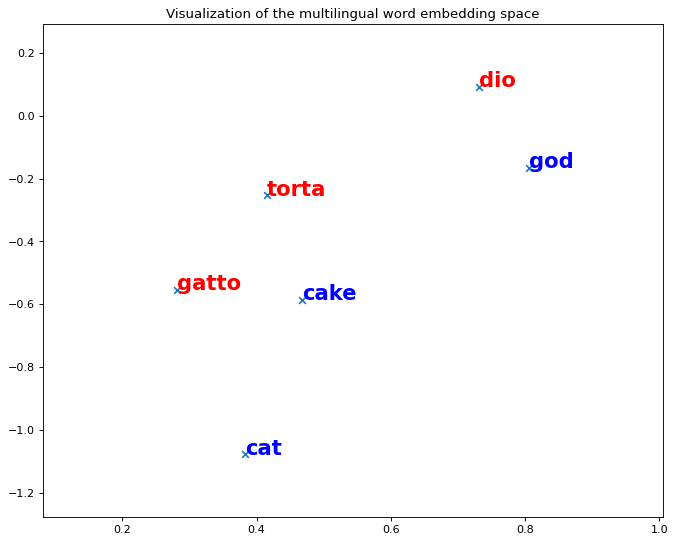

In [32]:
# get 5 random input words
src_words = ['cat', 'cake', "god"]
tgt_words = ['gatto', 'torta', "dio"]

# assert words in dictionaries
for sw in src_words:
    assert sw in embedding_word2id_en, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in embedding_word2id_it, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, embedding_word2id_en, embeddings_en, tgt_words, embedding_word2id_it, embeddings_it, pca)

## Correctly format the texts

In [33]:
# Deinfe some variables
VOCABULARY_SIZE = 50000
EMBEDDING_DIM = 300
SEQ_LENGTH = 300

# We insert <start>, <pad>, <unk>
INDEX_FROM = 3

In [34]:
X_train_ita = ['<start> ' + x for x in X_train_ita]
X_test_ita = ['<start> ' + x for x in X_test_ita]

In [35]:
X_train_en = ['<start> ' + x for x in X_train_en]
X_test_en = ['<start> ' + x for x in X_test_en]

In [36]:
# create the tokenizer
t_en = Tokenizer(oov_token="<unk>", num_words=VOCABULARY_SIZE+INDEX_FROM-1, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

# fit the tokenizer on the documents
t_en.fit_on_texts(X_train_en)

t_en.word_index['<pad>'] = 0
t_en.index_word[0] = '<pad>'

# summarize what was learned
print("List of all the words and relative (local) id: \n\n", t_en.word_index)

X_train_en_encoded = t_en.texts_to_sequences(X_train_en)
X_test_en_encoded = t_en.texts_to_sequences(X_test_en)

List of all the words and relative (local) id: 

 {'<unk>': 1, '<start>': 2, 'a': 3, 'bitch': 4, 'i': 5, 'rt': 6, 'the': 7, 'you': 8, 'to': 9, 'and': 10, 'my': 11, 'that': 12, 't': 13, '128514': 14, 'bitches': 15, 'in': 16, 'co': 17, 'http': 18, 'is': 19, 'me': 20, 'like': 21, 'on': 22, 'of': 23, 'hoes': 24, 'be': 25, 'this': 26, 'pussy': 27, 'for': 28, 'it': 29, 'hoe': 30, 'with': 31, '8220': 32, '8221': 33, "i'm": 34, 'ass': 35, 'all': 36, 'up': 37, 'your': 38, 'if': 39, 'but': 40, 'just': 41, "don't": 42, 'get': 43, 'fuck': 44, 'so': 45, 'they': 46, 'no': 47, 'these': 48, 'when': 49, 'got': 50, 'shit': 51, 'u': 52, 'nigga': 53, '8230': 54, 'not': 55, 'are': 56, 'was': 57, 'her': 58, 'she': 59, 'trash': 60, 'at': 61, 'lol': 62, 'out': 63, 'have': 64, 'he': 65, 'amp': 66, "ain't": 67, 'some': 68, 'about': 69, 'what': 70, 'know': 71, 'can': 72, 'niggas': 73, 'do': 74, 'we': 75, 'them': 76, 'one': 77, 'love': 78, 'how': 79, "it's": 80, 'who': 81, 'as': 82, 'or': 83, '128557': 84, 'yo': 

In [37]:
t_it = Tokenizer(oov_token="<unk>", num_words=VOCABULARY_SIZE+INDEX_FROM-1, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

t_it.fit_on_texts(X_train_ita)

t_it.word_index['<pad>'] = 0
t_it.index_word[0] = '<pad>'

print("List of all the words and relative (local) id: \n\n", t_it.word_index)

# integer encode documents
X_train_ita_encoded = t_it.texts_to_sequences(X_train_ita)
X_test_ita_encoded = t_it.texts_to_sequences(X_test_ita)

List of all the words and relative (local) id: 

 {'<unk>': 1, '<start>': 2, 'di': 3, 'e': 4, 'che': 5, 'user': 6, 'a': 7, 'la': 8, 'url': 9, 'non': 10, 'i': 11, 'il': 12, 'in': 13, 'per': 14, 'è': 15, 'un': 16, 'ma': 17, 'puttana': 18, 'porca': 19, 'sono': 20, 'le': 21, 'da': 22, 'una': 23, 'con': 24, 'rom': 25, 'si': 26, 'gli': 27, 'migranti': 28, 'se': 29, 'tutti': 30, 'della': 31, 'cazzo': 32, 'mi': 33, 'come': 34, 'immigrati': 35, 'ha': 36, 'del': 37, 'anche': 38, 'ci': 39, 'ti': 40, 'al': 41, 'dei': 42, 'lo': 43, 'co': 44, 't': 45, 'https': 46, 'loro': 47, 'io': 48, 'italia': 49, 'alla': 50, 'roma': 51, 'più': 52, 'solo': 53, 'italiani': 54, 'hanno': 55, 'perché': 56, 'sei': 57, 'o': 58, 'chi': 59, 'troia': 60, 'ho': 61, 'fare': 62, 'casa': 63, 'nel': 64, 'poi': 65, 'li': 66, 'tutto': 67, 'stranieri': 68, 'no': 69, 'ai': 70, 'questo': 71, 'noi': 72, 'cosa': 73, 'figa': 74, 'fa': 75, 'culo': 76, 'culona': 77, 'fatto': 78, 'quando': 79, 'tettona': 80, 'via': 81, 'ora': 82, 'questi'

In [38]:
#for italian
X_train_ita_padded = tf.keras.utils.pad_sequences(X_train_ita_encoded, maxlen=SEQ_LENGTH)
X_test_ita_padded = tf.keras.utils.pad_sequences(X_test_ita_encoded, maxlen=SEQ_LENGTH)

In [39]:
#for english
X_train_en_padded = tf.keras.utils.pad_sequences(X_train_en_encoded, maxlen=SEQ_LENGTH)
X_test_en_padded = tf.keras.utils.pad_sequences(X_test_en_encoded, maxlen=SEQ_LENGTH)

In [40]:
len(X_train_en_padded[76])

300

## Create the "local" embedding matrix

Now that we have:
- Embedding list
- Dictionary word → embedding id
- Local id representation of the words extracted from the tweets

We need to create the link between our found words and their representation in our multilingual embedding space.

We create an embedding matrix where each row contains the embedding of the word indexed by its row number (local id).

In [41]:
def create_embedding_matrix(target_word2id, embedding_word2id, embeddings, num_rows, num_columns):
    embedding_matrix = np.zeros((num_rows, num_columns))
    for word, i in target_word2id.items():
        if i >= num_rows:
            break
        if word in embedding_word2id:
            embedding_matrix[i] = embeddings[embedding_word2id[word]]
    return embedding_matrix

In [42]:
word2id_en = t_en.word_index
word2id_it = t_it.word_index

embedding_matrix_it = create_embedding_matrix(word2id_it, embedding_word2id_it, embeddings_it, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)
embedding_matrix_en = create_embedding_matrix(word2id_en, embedding_word2id_en, embeddings_en, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)

In [43]:
embedding_matrix_it

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
embedding_matrix_en

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Baseline

Class weights values in order to better train the models

In [45]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y_train_en), y = Y_train_en)
class_weights_dict = dict(zip(np.unique(Y_train_en), class_weights))
class_weights_dict

{0: 2.9786658653846154, 1: 0.6008607103891381}

### English


In [53]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train_en)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

nb_clf = BernoulliNB()

# Multiply each sample by the corresponding class
sample_weights = class_weights[Y_train_en]

nb_clf.fit(X_train_tfidf, Y_train_en, sample_weights)

BernoulliNB()

In [54]:
X_new_counts = count_vect.transform(X_test_en)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

test_ds_predicted = nb_clf.predict(X_new_tfidf)
test_ds_predicted

array([1, 1, 1, ..., 1, 1, 1])

In [55]:
print(metrics.classification_report(Y_test_en,test_ds_predicted))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       835
           1       0.96      0.96      0.96      4122

    accuracy                           0.93      4957
   macro avg       0.88      0.88      0.88      4957
weighted avg       0.93      0.93      0.93      4957



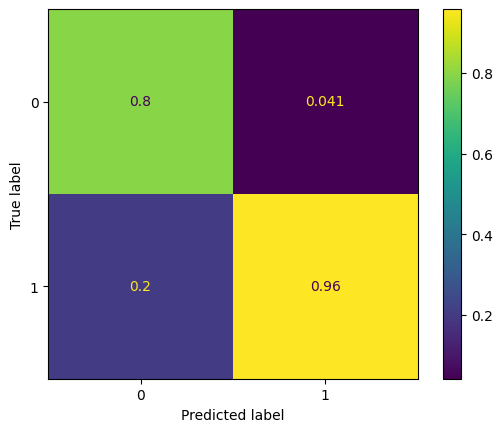

In [56]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en, test_ds_predicted , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [89]:
docs_new = ['i love pizza']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = nb_clf.predict(X_new_tfidf)

print(predicted)


[1]


 ### Italian


In [90]:
X_train_counts = count_vect.fit_transform(X_train_ita)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

nb_clf = BernoulliNB()

# Multiply each sample by the corresponding class
sample_weights = class_weights[Y_train_ita]

nb_clf.fit(X_train_tfidf, Y_train_ita, sample_weights)

BernoulliNB()

In [91]:
X_new_counts = count_vect.transform(X_test_ita)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

test_ds_predicted = nb_clf.predict(X_new_tfidf)
test_ds_predicted

array([0, 0, 1, ..., 0, 0, 0])

In [92]:
print(metrics.classification_report(Y_test_ita,test_ds_predicted))

              precision    recall  f1-score   support

           0       0.56      0.97      0.71      1143
           1       0.90      0.29      0.44      1225

    accuracy                           0.62      2368
   macro avg       0.73      0.63      0.57      2368
weighted avg       0.74      0.62      0.57      2368



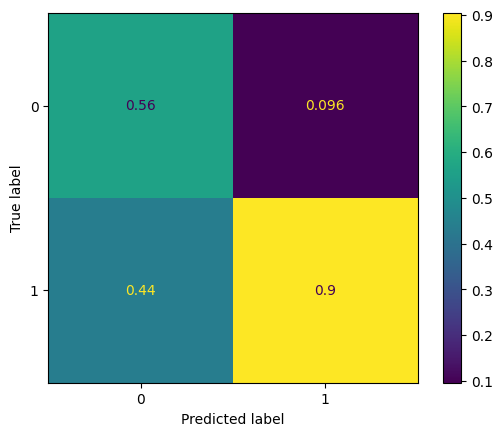

In [94]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita, test_ds_predicted , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [100]:
docs_new = ['bastardo coglione muori']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = nb_clf.predict(X_new_tfidf)

print(predicted)


[0]


## LSTM Model

From: https://github.com/mdabashar/Deep-Learning-Algorithms/blob/master/LSTM%20Hate%20Speech%20Detection.ipynb

BASELINE: https://www.researchgate.net/figure/Baseline-LSTM-model-architecture_fig2_363399494

In [101]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [103]:
WEIGHTS = embedding_matrix_en #embedding_matrix_it

#baseline LSTM architecture from the paper
def lstm_model(embedding_matrix=WEIGHTS, input_length = SEQ_LENGTH):
    input = keras.layers.Input(shape=(SEQ_LENGTH,), dtype='int32')
    encoder = keras.layers.Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=input_length, trainable=False)(input)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.5, return_sequences=True))(encoder)
    #x = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.5,return_sequences=True))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.Dense(1)(x)
    output = keras.layers.Activation('sigmoid')(x)
    model = Model(inputs=[input], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m,precision_m, recall_m]) #adamW
    return model

lstm_model = lstm_model()
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 300)          15000600  
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 128)         186880    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 128)               4915328   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [104]:
NUM_EPOCHS=20
BATCH_SIZE=32

earlystop = EarlyStopping(monitor='val_loss', patience=2)

lstm_model.fit(X_train_en_padded, Y_train_en, validation_data=(X_test_en_padded, Y_test_en), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlystop], class_weight=class_weights_dict)

print("\n")

# Final evaluation of the model
scores = lstm_model.evaluate(X_test_en_padded, Y_test_en)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
620/620 [==============================] - 35s 29ms/step - loss: 0.3107 - acc: 0.8636 - f1_m: 0.9078 - precision_m: 0.9703 - recall_m: 0.8609 - val_loss: 0.3147 - val_acc: 0.8658 - val_f1_m: 0.9108 - val_precision_m: 0.9943 - val_recall_m: 0.8429
Epoch 2/20
620/620 [==============================] - 16s 26ms/step - loss: 0.2217 - acc: 0.9049 - f1_m: 0.9390 - precision_m: 0.9880 - recall_m: 0.8970 - val_loss: 0.1891 - val_acc: 0.9169 - val_f1_m: 0.9469 - val_precision_m: 0.9887 - val_recall_m: 0.9101
Epoch 3/20
620/620 [==============================] - 18s 29ms/step - loss: 0.1929 - acc: 0.9151 - f1_m: 0.9456 - precision_m: 0.9901 - recall_m: 0.9072 - val_loss: 0.1793 - val_acc: 0.9163 - val_f1_m: 0.9465 - val_precision_m: 0.9892 - val_recall_m: 0.9089
Epoch 4/20
620/620 [==============================] - 17s 27ms/step - loss: 0.1745 - acc: 0.9195 - f1_m: 0.9488 - precision_m: 0.9922 - recall_m: 0.9108 - val_loss: 0.2175 - val_acc: 0.9112 - val_f1_m: 0.9427 - val_precision_m

155/155 [==============================] - 2s 11ms/step


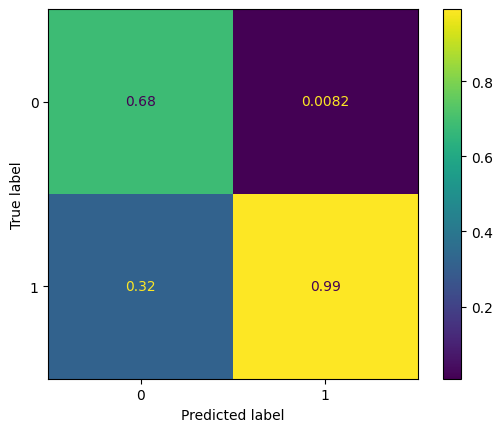

In [105]:
#Predict
y_prediction_en = lstm_model.predict(X_test_en_padded)
y_prediction_en = (y_prediction_en >= 0.5).astype(int)

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en, y_prediction_en , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [107]:
fake_tweet = "i fucking love pizza!!!!!!"
fake_tweet = t_en.texts_to_sequences([fake_tweet])
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH)

lstm_model.predict(fake_tweet)

1/1 [==============================] - 0s 43ms/step


array([[0.9721773]], dtype=float32)

### Change the embedding to ita

In [108]:
lstm_model.layers[1].set_weights([embedding_matrix_it])

74/74 [==============================] - 1s 11ms/step


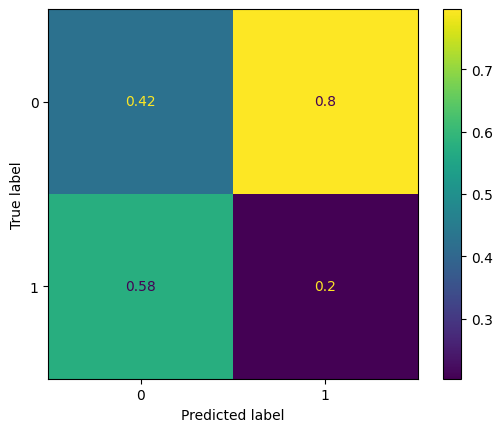

In [109]:
#Predict
y_prediction_ita = lstm_model.predict(X_test_ita_padded)
y_prediction_ita = (y_prediction_ita >= 0.5).astype(int)

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita, y_prediction_ita , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [110]:
slim = y_prediction_ita.reshape(-1)
hate = np.where(slim == 1)[0]
X_test_ita_padded[hate]
test = t_it.sequences_to_texts(X_test_ita_padded[hate])

In [111]:
test[230]

'<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

In [114]:
fake_tweet = "ti voglio bene idiota"
fake_tweet = t_it.texts_to_sequences([fake_tweet])
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH)

lstm_model.predict(fake_tweet)

1/1 [==============================] - 0s 53ms/step


array([[0.3235202]], dtype=float32)

## Definition of the model

Basic convolutional network taken from [this blog](https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/), single-value output ranging from 0 to 1 indicating if its a hate speech tweet or not.

Convolutional neural networks were designed to honor the spatial structure in image data while being robust to the position and orientation of learned objects in the scene.

This same principle can be used on sequences, such as the one-dimensional sequence of words in a movie review. The same properties that make the CNN model attractive for learning to recognize objects in images can help to learn structure in paragraphs of words, namely the techniques invariance to the specific position of features.

In [115]:
WEIGHTS = embedding_matrix_en #embedding_matrix_it

# Model
cnn_model = Sequential()
# ------
cnn_model.add(keras.layers.Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, input_length=SEQ_LENGTH, weights=[WEIGHTS], trainable=False))
# ------
cnn_model.add(keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(250, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          15000600  
                                                                 
 conv1d (Conv1D)             (None, 300, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 32)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dense_2 (Dense)             (None, 250)               1200250   
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                        

In [116]:
NUM_EPOCHS=10
BATCH_SIZE=64

earlystop = EarlyStopping(monitor='val_loss', patience=2)

cnn_model.fit(X_train_en_padded, Y_train_en, validation_data=(X_test_en_padded, Y_test_en), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlystop], class_weight=class_weights_dict)

print("\n")

# Final evaluation of the model
scores = cnn_model.evaluate(X_test_en_padded, Y_test_en)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
310/310 [==============================] - 10s 7ms/step - loss: 0.2922 - acc: 0.8823 - f1_m: 0.9243 - precision_m: 0.9724 - recall_m: 0.8857 - val_loss: 0.1861 - val_acc: 0.9217 - val_f1_m: 0.9507 - val_precision_m: 0.9892 - val_recall_m: 0.9156
Epoch 2/10
310/310 [==============================] - 2s 6ms/step - loss: 0.1615 - acc: 0.9284 - f1_m: 0.9548 - precision_m: 0.9930 - recall_m: 0.9204 - val_loss: 0.1627 - val_acc: 0.9312 - val_f1_m: 0.9572 - val_precision_m: 0.9842 - val_recall_m: 0.9322
Epoch 3/10
310/310 [==============================] - 2s 6ms/step - loss: 0.1288 - acc: 0.9408 - f1_m: 0.9630 - precision_m: 0.9953 - recall_m: 0.9334 - val_loss: 0.1658 - val_acc: 0.9334 - val_f1_m: 0.9586 - val_precision_m: 0.9835 - val_recall_m: 0.9356
Epoch 4/10
310/310 [==============================] - 2s 6ms/step - loss: 0.0977 - acc: 0.9563 - f1_m: 0.9729 - precision_m: 0.9976 - recall_m: 0.9498 - val_loss: 0.2332 - val_acc: 0.9203 - val_f1_m: 0.9495 - val_precision_m: 0.989

155/155 [==============================] - 0s 2ms/step


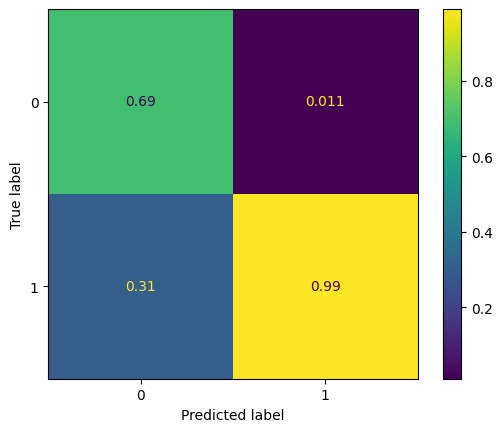

In [117]:
#Predict
y_prediction_en = cnn_model.predict(X_test_en_padded)
y_prediction_en = (y_prediction_en >= 0.5).astype(int)


#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en, y_prediction_en , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Some tests

In [135]:
id = 11

tweet = np.array([X_test_en_padded[id]])

print(test_en.iloc[id]['tweet'], " | ", test_en.iloc[id]['hate_speech'])
cnn_model.predict(tweet)

@Nien_Nunb what did you search? Gay redneck episode 1 play?  |  1
1/1 [==============================] - 0s 67ms/step


array([[0.20368257]], dtype=float32)

In [136]:
fake_tweet = "i fucking love pizzaaaaaaaaaaaaaaaa!!!!"
fake_tweet = t_en.texts_to_sequences([fake_tweet])
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH)

cnn_model.predict(fake_tweet)

1/1 [==============================] - 0s 20ms/step


array([[0.99534494]], dtype=float32)

### Ita

In [137]:
cnn_model.layers[0].set_weights([embedding_matrix_it])

74/74 [==============================] - 0s 2ms/step


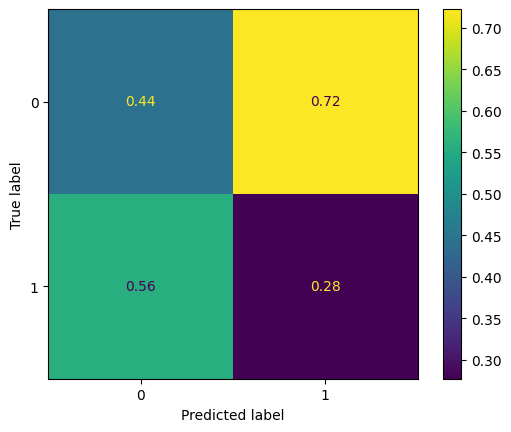

In [138]:
#Predict
y_prediction_ita = cnn_model.predict(X_test_ita_padded)
y_prediction_ita = (y_prediction_ita >= 0.5).astype(int)

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita, y_prediction_ita , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [139]:
slim = y_prediction_ita.reshape(-1)
hate = np.where(slim == 1)[0]
X_test_ita_padded[hate]
test = t_it.sequences_to_texts(X_test_ita_padded[hate])

In [140]:
test[42]

'<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

In [143]:
fake_tweet = "amo la cazzo di pizza"
fake_tweet = t_it.texts_to_sequences([fake_tweet])
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH)

cnn_model.predict(fake_tweet)

1/1 [==============================] - 0s 59ms/step


array([[0.40446776]], dtype=float32)

alora

non funziona molto bene anche se ho seguito per bene tutto quello che fa il tipo

1. secondo me è proprio per differenze linguistiche, teoricamente con i pesi dell'embedding in inglese ha capito come classificare i tweet riconoscendo la presenza di certe parole, e di conseguenza la loro posizione nello spazio dell'embedding
  
  cambiando l'embedding lui si aspetta di trovare parole brutte in certe posizioni spaziali con determinate relazioni che probabilmente non si preservano nello spazio italiano

2. nonostante i risultati sia in inglese che in ita non siano poi così male, secondo me non performa comunque bene, ma credo la motivazione sia 50/50 dati e modello

3. i dati non sono un gran chè (come sono classificati) e con il nostro modello semplice semplice secondo me scegle le label in maniera conservativa, sparando 1 appena trova una minima parolaccia

4. in italiano non ho la più pallida idea di cosa reputi parolaccia, puoi scrivere le peggio cose e non lo labellllerà come offesa, sus......

update rispetto qua sopra

1. Non è vero, ho dimostrato che l'embedding è quello multilingual, quindi fico, parole più o meno nella stessa posizione poichè lo spazio è "allineato"

  Il problema è che l'allineamento non è perfetto, cercando per NN si trovano le parole, ma ovviamente non sono vicine vicine, probabilmente questo nel modello fa si che la sua convinzione nel define qualcosa hate sia meno forte rispetto che in inglese, tipo poco sopra 0.5

2. in realtà no, dipende dal modello. Essendo cnn come detto cerca corrispondenze spaziali e quindi secondo me ha imparato a riconoscere certe parole come "nono word" e ogni volta che le trova aumenta notevolmente la probabilità di essere classificato hs (e.g i fucking love pizzzza)

3. forse si i dati non sono un granchè, e labella in maniera conservativa come detto in punto 2. Il vero problema forse sta anche nella differenza di come sono le frasi in italiano rispetto l'inglese. Forse in eng gli insulti sono più diretti/semplici (?) mentre in italiano sono molto più lunghi e boh incentrati sui migranti/politica (?)

4. Confermo :)


---

# TODO

- stampicciare modificando la rete LSTM (se abbiamo voglia anche la cnn)
- abbiamo gestico class imbalance in naive baises?
- facciamo un pelo di random undersampling(?)
- METTERE NOSTRO CARO AMICO BERT, multilinguale sta volta

---

# Transformers


In [42]:
model_checkpoint = "bert-base-multilingual-cased"

In [43]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [44]:
hg_train_en = datasets.Dataset(pa.Table.from_pandas(train_en))
hg_test_en = datasets.Dataset(pa.Table.from_pandas(test_en))

hg_test_ita = datasets.Dataset(pa.Table.from_pandas(test_ita))

hg_ds = datasets.DatasetDict({"train":hg_train_en, "test":hg_test_en})

hg_ds["train"] = hg_ds["train"].remove_columns(["__index_level_0__"]) # remove unwanted column
hg_ds["test"] = hg_ds["test"].remove_columns(["__index_level_0__"]) # remove unwanted column
hg_ds["train"] = hg_ds["test"].rename_column("hate_speech", "label")
hg_ds["test"] = hg_ds["test"].rename_column("hate_speech", "label")

In [45]:
hg_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 4957
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 4957
    })
})

In [46]:
def preprocess_functions(batch):
  # Tokenize the input data
  return tokenizer(
    batch["tweet"],
    #max_length=SEQ_LENGTH,
    #padding=True,
    truncation=True)

In [47]:
tokenized_datasets_en = hg_ds.map(preprocess_functions, batch_size=32, batched=True)
#tokenized_datasets_en.set_format(type="tensorflow", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [48]:
tokenized_datasets_en

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
    test: Dataset({
        features: ['label', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
})

In [49]:
tokenized_datasets_en['train'][0]

{'label': 1,
 'tweet': 'RT @Cesar_Wtx: Pink nipples are cute but some be looking nasty than a bitch! &#128567;',
 'input_ids': [101,
  56898,
  137,
  70418,
  168,
  160,
  10123,
  10686,
  131,
  23413,
  10414,
  16587,
  11268,
  10301,
  21610,
  10112,
  10473,
  11152,
  10347,
  34279,
  12947,
  11195,
  11084,
  169,
  17684,
  10269,
  106,
  111,
  108,
  75800,
  11211,
  11305,
  132,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [50]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [52]:
tf_train_set = tokenized_datasets_en["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask",  "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

tf_test_set = tokenized_datasets_en["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [53]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5

batches_per_epoch = len(tokenized_datasets_en["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [54]:
class_weights[1]

0.6008607103891381

In [55]:
def weighted_binary_crossentropy(y_true, y_pred):     # Apply weights based on class labels
  weights = y_true * class_weights_dict.get(1) + (1 - y_true) * class_weights_dict.get(0)
  #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  weighted_loss = loss(y_true, y_pred) * float(weights)
  mean_loss = tf.reduce_mean(weighted_loss)
  return mean_loss#tf.keras.metrics.Mean(weighted_loss)

In [56]:
#model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy)

model.compile(optimizer=optimizer)

In [57]:
model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=num_epochs)

Epoch 1/5
310/310 [==============================] - 210s 485ms/step - loss: 0.2120 - val_loss: 0.1103
Epoch 2/5
310/310 [==============================] - 123s 397ms/step - loss: 0.1168 - val_loss: 0.0661
Epoch 3/5
310/310 [==============================] - 114s 367ms/step - loss: 0.0786 - val_loss: 0.0464
Epoch 4/5
310/310 [==============================] - 123s 397ms/step - loss: 0.0418 - val_loss: 0.0270
Epoch 5/5
310/310 [==============================] - 122s 393ms/step - loss: 0.0270 - val_loss: 0.0170


In [102]:
sentences = [
    "Mi piace il gelato",
    "Che belli i gattini"
]

In [105]:
tokenized = tokenizer(sentences, return_tensors="np", padding="longest")

outputs = model(tokenized).logits

print(outputs)
print()

classifications = np.argmax(outputs, axis=1)
print(classifications)

tf.Tensor(
[[ 1.3189756 -1.6710014]
 [-2.2064912  1.9960613]], shape=(2, 2), dtype=float32)

[0 1]


In [144]:
hg_test_en

Dataset({
    features: ['hate_speech', 'tweet', '__index_level_0__'],
    num_rows: 4957
})

In [124]:
from tqdm import tqdm
res = []
start = 0
end = 100
for i in tqdm(range(0, 2200, 100)):
  tokenize = tokenizer(hg_test_ita['text'][i:end], return_tensors="np", padding="longest")
  output = model(tokenize).logits
  classification = np.argmax(output, axis=1)
  res.append(classification)
  end = end + 100

100%|██████████| 22/22 [00:18<00:00,  1.21it/s]


In [141]:
x = np.reshape(res, (len(res), 100)).T
y = x.reshape(-1)
y.shape

(2200,)

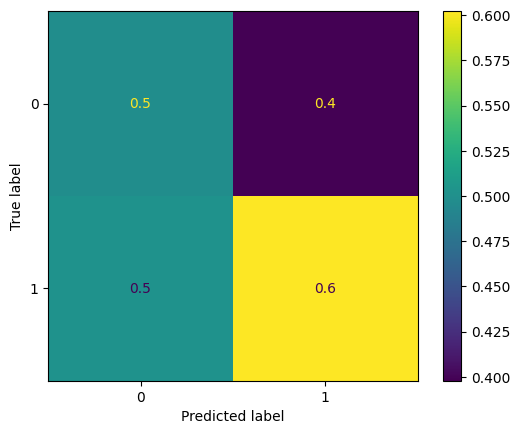

In [143]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita[:2200], y , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [147]:
from tqdm import tqdm
res = []
start = 0
end = 100
for i in tqdm(range(0, 4800, 100)):
  tokenize = tokenizer(hg_test_en['tweet'][i:end], return_tensors="np", padding="longest")
  output = model(tokenize).logits
  classification = np.argmax(output, axis=1)
  res.append(classification)
  end = end + 100

100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


In [148]:
x = np.reshape(res, (len(res), 100)).T
y = x.reshape(-1)
y.shape

(4800,)

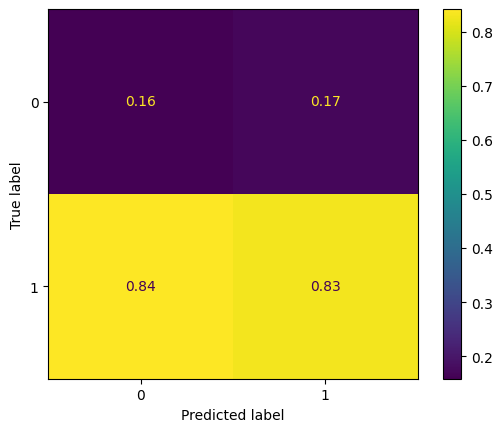

In [150]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en[:4800], y , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=this+is+shit